### Importing Libraries

In [110]:
# dataframe
import pandas as pd
import numpy as np

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import scikitplot
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# preprocessing
import nltk 
# nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# modeling
import gensim
import time

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Loading Dataset

In [2]:
DATASET_COLUMNS = ["target", "id", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8
df = pd.read_csv('data.csv', encoding = DATASET_ENCODING , names = DATASET_COLUMNS)
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.drop(['id', 'date', 'flag', 'user'], axis = 1, inplace = True)
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.target.replace([0, 2, 4], ['negative', 'neutral', 'positive'], inplace = True)
df.head()

,target,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


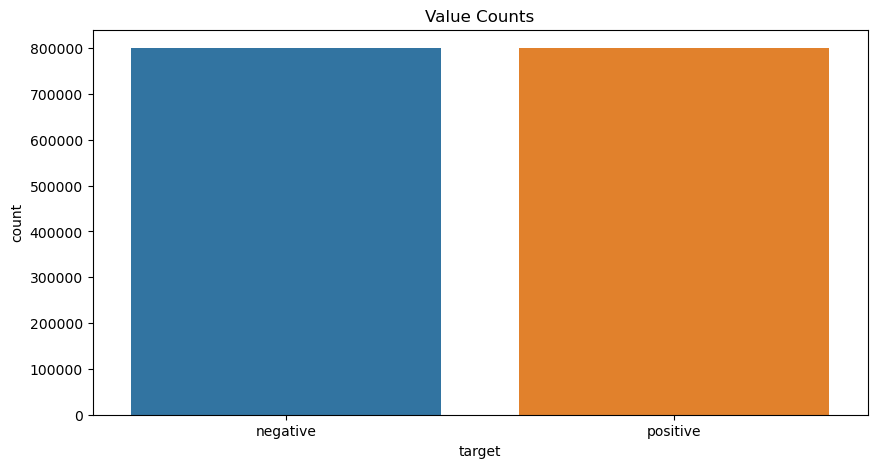

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(df, x = "target")
plt.title('Value Counts')
plt.show()

### Data Cleaning

#### 1) duplicate text

In [6]:
initial = df.shape[0]
df.drop_duplicates('text',keep='first', inplace=True)
df.reset_index(inplace = True, drop = True)
after = df.shape[0]

print("Initial Row Size",initial)
print("After Dropping",after)
print("Rows Deleted",(initial-after))

Initial Row Size 1600000
After Dropping 1581466
Rows Deleted 18534


#### 2) null values

In [7]:
initial = df.shape[0]
df = df.dropna()
after = df.shape[0]

print("Initial Row Size",initial)
print("After Deletion",after)
print("Rows Deleted",(initial-after))

Initial Row Size 1581466
After Deletion 1581466
Rows Deleted 0


### Preprocessing
* Removing stop words.
* Removing HTML tags and Mentions.
* Stemming/Lemmatization.

NOTE: Stemming removes the tail of the word while lemmatization takes the semantic meaning into consideration.
EXAMPLE : 
1) Stemming: reading, reads, read -> read
2) Lemmatization: better -> good

In [8]:
stop_words = list(set(stopwords.words('english')))
stemmer = SnowballStemmer('english')

#### 1) stopwords

In [9]:
print(stop_words)

["shouldn't", 'other', 'he', 'you', 'were', 'doesn', 'yours', 'y', 'o', 'but', 'all', 'yourself', 'only', 'she', "you're", 'can', 'ain', 'off', 'mustn', 'own', 'is', 'wouldn', 're', 'a', 'for', 'before', 'your', 'are', 'same', 'there', 'shouldn', "doesn't", 'him', 'further', 'just', 'i', 'here', 'myself', 'been', 's', 'am', 'haven', 'who', 'our', "shan't", 'had', 'where', 'now', 'both', 'during', 'this', 'or', 'into', 'them', 'did', 'too', 've', 'no', "couldn't", 'was', 'as', 'have', 'when', 'we', 'why', 'themselves', 'having', 'ourselves', 'theirs', 'below', 'out', 'most', 'very', 'couldn', 'of', 'until', "won't", 'how', 'and', 'herself', 'again', "weren't", 'from', 'doing', 'an', 'at', 'which', 'then', 'yourselves', 'has', "don't", 'ours', 'because', 'wasn', 'her', 'that', 'about', 'whom', "she's", 'those', 'so', 'through', 'these', "you've", 'the', 'do', 'they', 'aren', 'few', "mightn't", 'what', "haven't", 'ma', 'me', 'with', 'in', 'over', 'it', 'hadn', 't', 'don', 'needn', 'should

In [10]:
negative_stop_words = []
for i in stop_words:
    if 'no' in i:
        negative_stop_words.append(str(i))
    elif "n't" in i:
        negative_stop_words.append(str(i))
        
print(negative_stop_words)

["shouldn't", "doesn't", "shan't", 'now', 'no', "couldn't", "won't", "weren't", "don't", "mightn't", "haven't", 'not', "aren't", "mustn't", "hadn't", "isn't", "didn't", "wouldn't", "needn't", "hasn't", 'nor', "wasn't"]


In [11]:
stop = set(stop_words) - set(negative_stop_words)
stop_words = stop
print(stop_words)

{'other', 'he', 'you', 'were', 'doesn', 'yours', 'y', 'o', 'only', 'but', 'all', 'yourself', 'she', "you're", 'can', 'ain', 'off', 'mustn', 'own', 'is', 'wouldn', 're', 'a', 'for', 'before', 'your', 'are', 'same', 'there', 'shouldn', 'him', 'further', 'just', 'i', 'here', 'myself', 'been', 's', 'am', 'haven', 'who', 'our', 'had', 'where', 'both', 'during', 'this', 'or', 'into', 'them', 'did', 'too', 've', 'was', 'as', 'have', 'when', 'we', 'why', 'themselves', 'having', 'ourselves', 'theirs', 'below', 'out', 'most', 'very', 'couldn', 'of', 'until', 'how', 'and', 'herself', 'again', 'from', 'doing', 'an', 'at', 'which', 'then', 'yourselves', 'has', 'ours', 'because', 'wasn', 'her', 'that', 'about', 'whom', "she's", 'those', 'so', 'through', 'these', "you've", 'the', 'do', 'they', 'aren', 'few', 'what', 'ma', 'me', 'with', 'in', 'over', 'it', 'hadn', 't', 'don', 'needn', 'should', 'up', "you'll", "it's", "that'll", 'after', 'down', 'once', 'isn', 'himself', 'does', 'will', 'be', 'll', 'h

#### 2) stemming

In [12]:
print('reading : ', stemmer.stem('reading'))
print('reading : ', stemmer.stem('reads'))
print('reading : ', stemmer.stem('read'))

reading :  read
reading :  read
reading :  read


#### 3) text filtering

In [13]:
def cleanhtml(rev):
    tag = re.compile('<.*?>https?://\S+|www\.\S+')
    clean = re.sub(tag,'',rev) # '' is used to replace with.
    return clean

In [14]:
def cleanpunc(rev):
    tagg = re.compile('[?|!|\'|\"|#|.|,|(|)|\|\/]')
#     tagg = re.compile('[?|!|@|\'|\"|#|.|,|(|)|\|\/|_|-|&|$|%|^|+|=|<|>|:|;]')[?|!|\'|\"|#|.|,|(|)|\|\/]
    clean = re.sub(tagg,'',rev)
    return clean

In [15]:
i=0
strl = ''
final_string = []
all_pos_words = [] # store words with positive reviews
all_neg_words = [] # store words with negative reviews
s = ''
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
userPattern       = '@[^\s]+'

In [16]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [18]:
sentence = []
for sent in df['text'].values:
#     print(sent)
    sentence.append(sent)
    filtered_sentence = []
    sent = cleanhtml(sent)
    sent = re.sub(userPattern,'', sent)  
    sent = re.sub(sequencePattern, seqReplacePattern, sent)
    for emoji in emojis.keys():
            sent = sent.replace(emoji, "EMOJI" + emojis[emoji])  
    for w in sent.split():
#         print(w)
        cleaned_words = cleanpunc(w)
        if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
            if (cleaned_words.lower() not in stop_words):
                stemmed = (stemmer.stem(cleaned_words.lower()))
                filtered_sentence.append(stemmed)
#                 print(filtered_sentence)
            else:
                continue
        else:
            continue
    strl = " ".join(filtered_sentence)
#     print(strl)
    final_string.append(strl)
    i+=1

In [19]:
df['filtered text'] = final_string
df.head()

,target,text,filtered text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that bummer shoulda got david carr third day
1,negative,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
2,negative,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest bound
3,negative,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,negative,"@nationwideclass no, it's not behaving at all....",not behav mad cant see


### Train-Test Split
Splitting the dataset into train and test set.

In [20]:
df_train, df_test = train_test_split(df, test_size = 1-TRAIN_SIZE, random_state = 42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1265172
TEST size: 316294


### Word Cloud
#### 1) negative reviews

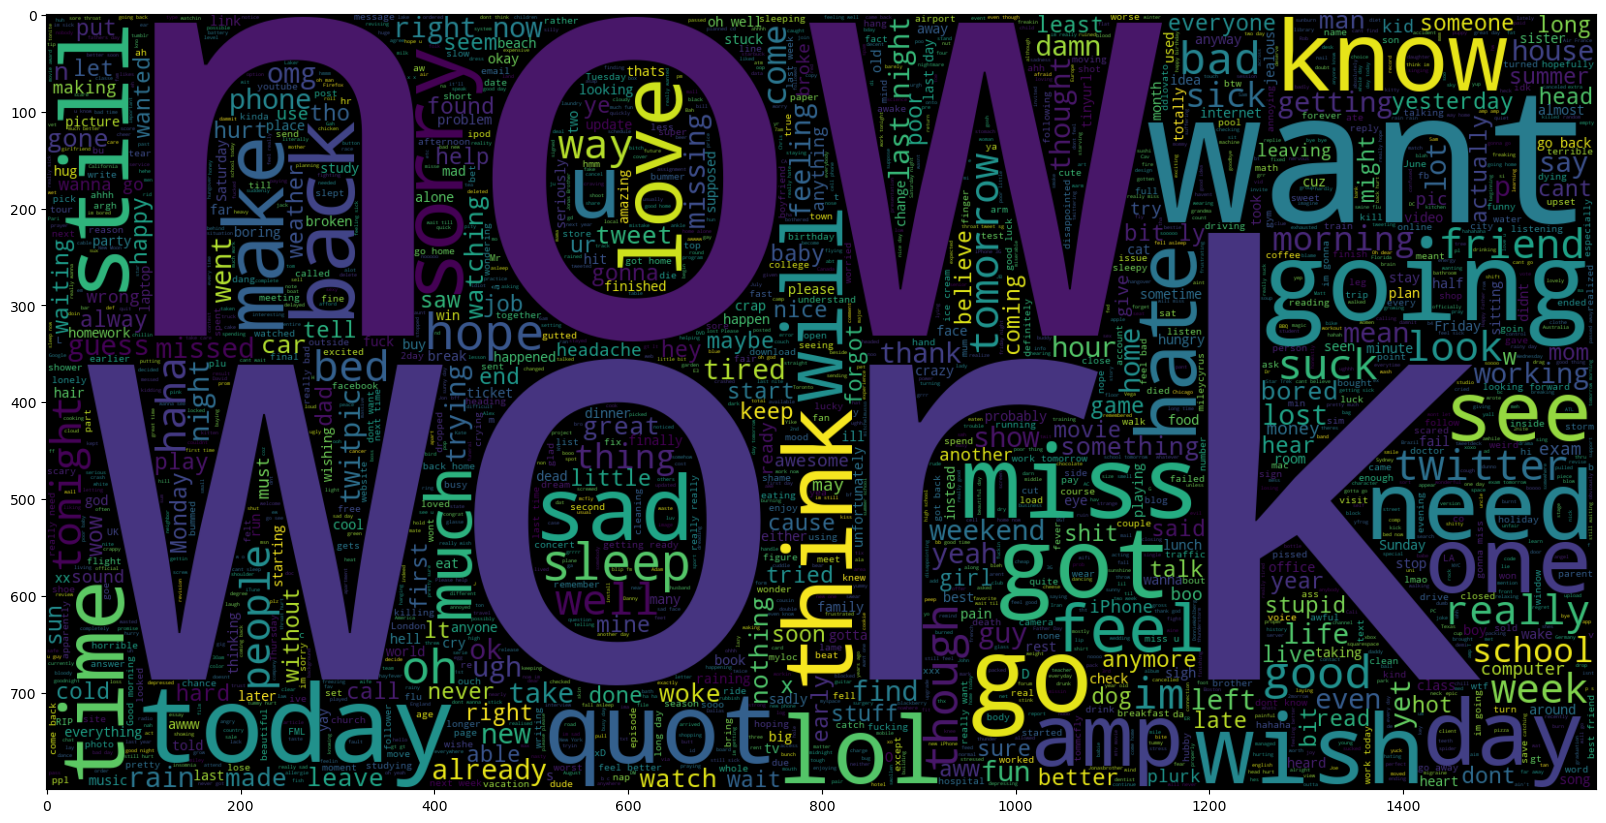

In [21]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_train[df_train.target == 'negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

#### 2) positive reviews

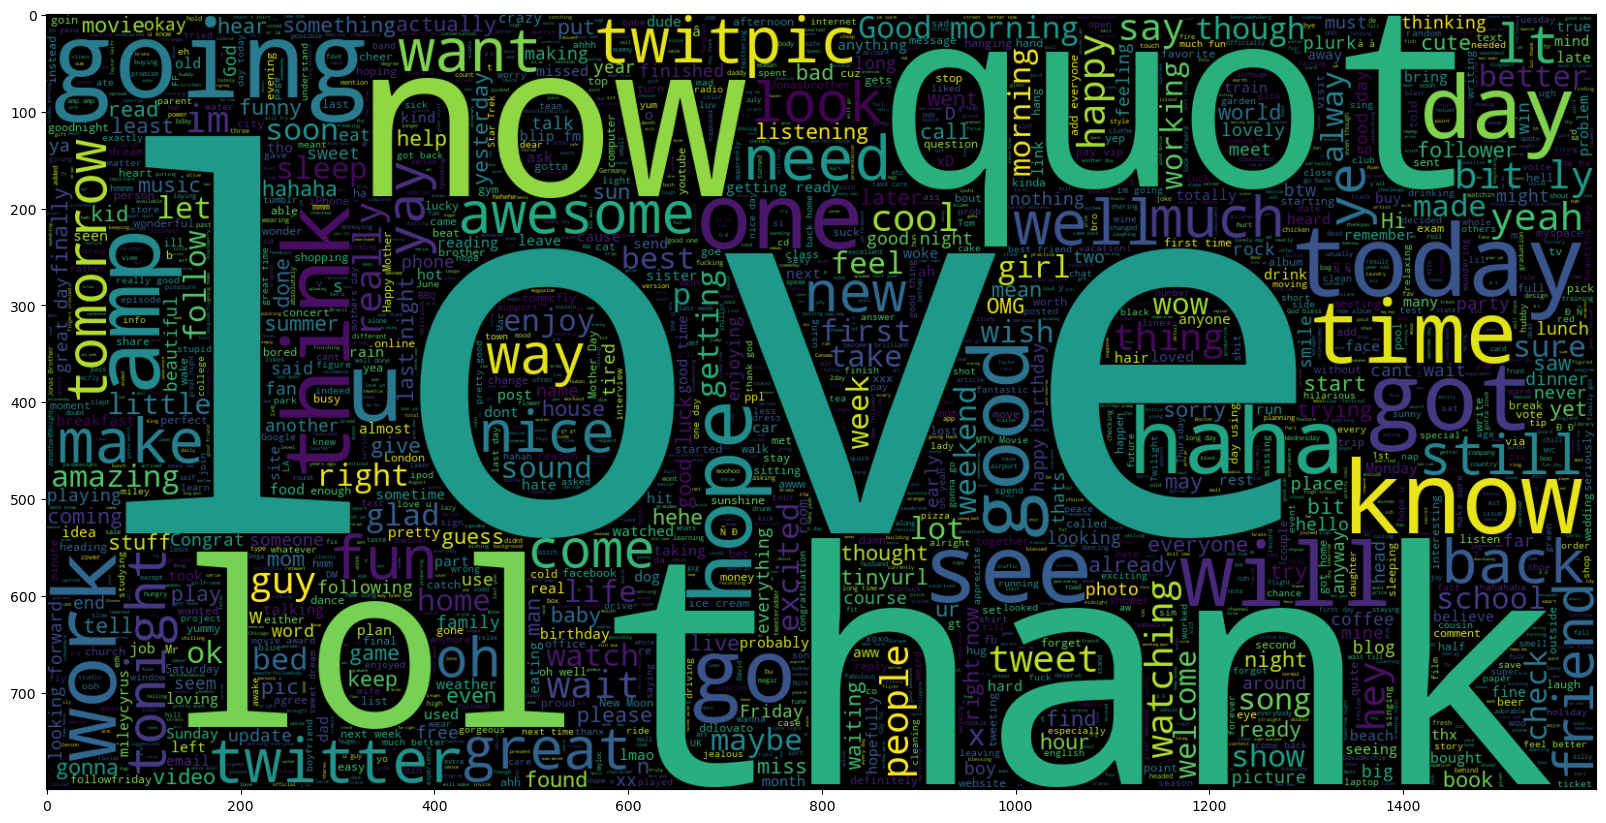

In [22]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_train[df_train.target == 'positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Word2Vec
Converting the filtered text into vectors.

In [23]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [24]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size = W2V_SIZE, 
                                            window = W2V_WINDOW, 
                                            min_count = W2V_MIN_COUNT, 
                                            workers = 8)

In [25]:
string = [t.split() for t in df_train['filtered text']]

In [26]:
w2v_model.build_vocab(string)

In [27]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 21466


In [28]:
%%time
w2v_model.train(string, total_examples = len(string), epochs = W2V_EPOCH)

CPU times: user 9min 53s, sys: 3.08 s, total: 9min 56s
Wall time: 1min 39s


(234821141, 271678880)

In [35]:
w2v_model.wv.most_similar("great") 

[('fantast', 0.7489005923271179),
 ('good', 0.6879242062568665),
 ('awesom', 0.678628146648407),
 ('amaz', 0.6191591620445251),
 ('fabul', 0.591560423374176),
 ('fab', 0.5834235548973083),
 ('nice', 0.5631232857704163),
 ('enjoy', 0.5420747399330139),
 ('excel', 0.5114708542823792),
 ('wonder', 0.4936223030090332)]

### Tokenizer

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['filtered text'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 247986


Now we got a tokenizer object, which can be used to covert any word into a Key in dictionary. Since we are going to build a sequence model. We should feed in a sequence of numbers to it

In [41]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen = 300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen = 300)

### Label Encoding

In [42]:
labels = df_train.target.unique().tolist()
labels

['positive', 'negative']

In [45]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train['target'].tolist())
y_test = encoder.transform(df_test['target'].tolist())

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1265172,)
y_test (316294,)


In [46]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1265172, 1)
y_test (316294, 1)


### Dataset

In [51]:
print('-----------------------')
print("X train :", x_train.shape)
print("y train :", y_train.shape)
print('-----------------------')
print("X test :", x_test.shape)
print("y test :", y_test.shape)
print('-----------------------')

-----------------------
X train : (1265172, 300)
y train : (1265172, 1)
-----------------------
X test : (316294, 300)
y test : (316294, 1)
-----------------------


### Embedding layer
Embedding allows for representation of similar words with similar encoding.

In [58]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(247986, 300)


In [60]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights = [embedding_matrix], 
                            input_length = SEQUENCE_LENGTH, trainable = False)

### Build Model

In [62]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128,activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='sigmoid'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          74395800  
                                                                 
 lstm (LSTM)                 (None, 300, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)               

In [63]:
callbacks = [ ReduceLROnPlateau(monitor = 'val_loss', patience = 5, cooldown = 0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [65]:
SEQUENCE_LENGTH = 300

history = model.fit(x_train, y_train,
                    batch_size = 1024,
                    epochs = 8,
                    validation_split = 0.1,
                    verbose = 1,
                    callbacks = callbacks)

Epoch 1/8
1112/1112 [==============================] - 16608s 15s/step - loss: 0.5293 - accuracy: 0.7359 - val_loss: 0.4936 - val_accuracy: 0.7557 - lr: 0.0010
Epoch 2/8
1112/1112 [==============================] - 30082s 27s/step - loss: 0.4927 - accuracy: 0.7582 - val_loss: 0.4878 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 3/8
1112/1112 [==============================] - 39018s 35s/step - loss: 0.4810 - accuracy: 0.7655 - val_loss: 0.4780 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 4/8
1112/1112 [==============================] - 4693s 4s/step - loss: 0.4723 - accuracy: 0.7708 - val_loss: 0.4773 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 5/8
1112/1112 [==============================] - 7573s 7s/step - loss: 0.4650 - accuracy: 0.7753 - val_loss: 0.4757 - val_accuracy: 0.7675 - lr: 0.0010
Epoch 6/8
1112/1112 [==============================] - 23816s 21s/step - loss: 0.4579 - accuracy: 0.7796 - val_loss: 0.4770 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 7/8
1112/1112 [=======================

### Accuracy

In [82]:
score = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

309/309 [==============================] - 366s 1s/step - loss: 0.4819 - accuracy: 0.7645

ACCURACY: 0.7644723057746887
LOSS: 0.4818587899208069


### Performance Plot

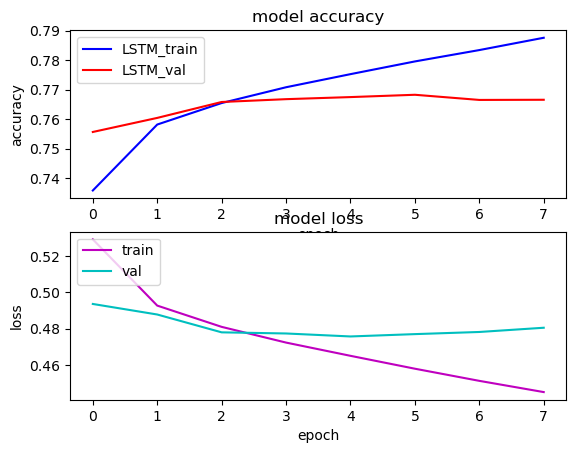

In [83]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

### Confusion matrix

In [91]:
scores = model.predict(x_test)

9885/9885 [==============================] - 1428s 144ms/step


In [144]:
y_pred = np.argmax(scores, axis =1)
y = df_test.target.to_list()

In [149]:
def decode_sentiment(score):
    return "positive" if score>0.5 else "negative"

y_pred_1d = [decode_sentiment(score) for score in y_pred]

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

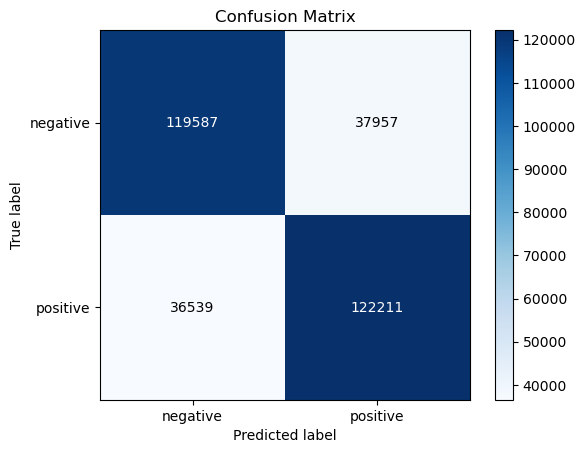

In [151]:
scikitplot.metrics.plot_confusion_matrix(y, y_pred_1d)

In [153]:
print(classification_report(y, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.76    157544
    positive       0.76      0.77      0.77    158750

    accuracy                           0.76    316294
   macro avg       0.76      0.76      0.76    316294
weighted avg       0.76      0.76      0.76    316294



In [156]:
from tensorflow.keras.models import load_model
model.save('./lstmmodel.h5')